In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Установка необходимых библиотек
!pip install segmentation_models_pytorch albumentations nibabel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Импорт библиотек
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
import nibabel as nib
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import random
import time

Датасет: [3D Liver segmentation](https://www.kaggle.com/datasets/prathamgrover/3d-liver-segmentation?resource=download)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
root = "/content/drive/MyDrive/Сегментация печени/Task03_Liver_rs"

In [23]:
im_paths = glob(f"{root}/imagesTr/*.nii")
gt_paths = glob(f"{root}/labelsTr/*.nii")
print(f'Количество стоковых nii файлов: {len(im_paths)}')
print(f'Количество размеченных файлов: {len(gt_paths)}')

Количество стоковых nii файлов: 123
Количество размеченных файлов: 123


In [37]:
im_total_counter = 0
gt_total_counter = 0
for i in range(len(im_paths)):
  if i % 10 == 0:
    print(f'{i}/{len(im_paths)}')

  im_total_counter += len(nib.load(im_paths[i]).get_fdata().transpose(2, 1, 0))
  gt_total_counter += len(nib.load(gt_paths[i]).get_fdata().transpose(2, 1, 0))

  if i == len(im_paths):
    print(f'{i}/{len(im_paths)}')

0/123
10/123
20/123
30/123
40/123
50/123
60/123
70/123
80/123
90/123
100/123
110/123
120/123


In [36]:
print(f'В среднем в стоковых nii файлах {round(im_total_counter / len(im_paths), 2)} срезов')
print(f'В среднем в размеченных файлах {round(gt_total_counter / len(gt_paths), 2)} срезов')

В среднем в стоковых nii файлах 159.38 срезов
В среднем в размеченных файлах 159.38 срезов


In [ ]:
class CustomSegmentationDataset(Dataset):

    def __init__(self, root, transformations=None):
        im_nii_paths = sorted(glob(f"{root}/imagesTr/*.nii"))
        gt_nii_paths = sorted(glob(f"{root}/labelsTr/*.nii"))

        self.ims = []
        self.gts = []

        for index, (im_nii, gt_nii) in enumerate(zip(im_nii_paths, gt_nii_paths)):
            if index == 50:
                break
            print(f"Конвертация Nifti файла номер {index + 1}...")
            nii_im_data, nii_gt_data = self.read_nii(im_nii, gt_nii)

            for im, gt in zip(nii_im_data, nii_gt_data):
                if len(np.unique(gt)) == 2:
                    self.ims.append(im)
                    self.gts.append(gt)

        self.transformations = transformations
        self.n_cls = 2

        assert len(self.ims) == len(self.gts)

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        im, gt = self.ims[idx], self.gts[idx]
        if self.transformations:
            im, gt = self.apply_transformations(im, gt)

        im = self.preprocess_im(im)
        gt[gt > 1] = 1

        return im.float(), gt.unsqueeze(0).float()

    def preprocess_im(self, im):
        max_val = torch.max(im)
        im[im < 0] = 0
        return im / max_val

    def read_nii(self, im, gt):
        return nib.load(im).get_fdata().transpose(2, 1, 0), nib.load(gt).get_fdata().transpose(2, 1, 0)

    def apply_transformations(self, im, gt):
        transformed = self.transformations(image=im, mask=gt)
        return transformed["image"], transformed["mask"]


In [ ]:
def get_dataloader(root, transformations, batch_size, split=[0.9, 0.05, 0.05], num_workers=4):
    assert sum(split) == 1., "Сумма долей должна быть равна 1"
    ds = CustomSegmentationDataset(root=root, transformations=transformations)

    # Минимальные размеры для каждого подмножества
    tr_len = max(int(len(ds) * split[0]), 1)
    val_len = max(int(len(ds) * split[1]), 1)
    test_len = max(len(ds) - (tr_len + val_len), 1)

    # Корректировка, если общая сумма превышает длину набора данных
    if tr_len + val_len + test_len > len(ds):
        tr_len = len(ds) - val_len - test_len

    tr_ds, val_ds, test_ds = random_split(ds, [tr_len, val_len, test_len])
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=num_workers)
    return tr_dl, val_dl, test_dl, ds.n_cls

In [ ]:
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose([A.Resize(im_h, im_w), ToTensorV2(transpose_mask=True)])
tr_dl, val_dl, test_dl, n_cls = get_dataloader(root=root, transformations=trans, batch_size=16)

Конвертация Nifti файла номер 1...
Конвертация Nifti файла номер 2...
Конвертация Nifti файла номер 3...
Конвертация Nifti файла номер 4...
Конвертация Nifti файла номер 5...
Конвертация Nifti файла номер 6...
Конвертация Nifti файла номер 7...
Конвертация Nifti файла номер 8...
Конвертация Nifti файла номер 9...
Конвертация Nifti файла номер 10...
Конвертация Nifti файла номер 11...
Конвертация Nifti файла номер 12...
Конвертация Nifti файла номер 13...
Конвертация Nifti файла номер 14...
Конвертация Nifti файла номер 15...
Конвертация Nifti файла номер 16...
Конвертация Nifti файла номер 17...
Конвертация Nifti файла номер 18...
Конвертация Nifti файла номер 19...
Конвертация Nifti файла номер 20...
Конвертация Nifti файла номер 21...
Конвертация Nifti файла номер 22...
Конвертация Nifti файла номер 23...
Конвертация Nifti файла номер 24...
Конвертация Nifti файла номер 25...
Конвертация Nifti файла номер 26...
Конвертация Nifti файла номер 27...
Конвертация Nifti файла номер 28...
К

In [ ]:
# for batch in tr_dl:
#   image, label = batch
#   print(image.shape)

In [ ]:
def plot_image(ax, image):
    ax.imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("Оригинальное изображение")
    ax.axis("off")

def plot_gt(ax, gt_image):
    ax.imshow(gt_image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("GT маска (правильная маска)")
    ax.axis("off")

def plot_pred(ax, pred_image):
    ax.imshow(pred_image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("Предсказанная маска")
    ax.axis("off")

def visualize_dataset(dataloader, num_images, model=None):
    columns = 2
    if model:
      columns = 3
      model.eval()
    fig, axes = plt.subplots(num_images, columns, figsize=(20, 25))

    for i, batch in enumerate(dataloader):
        if i >= num_images:
            break
        images, gt = batch
        images = images.to(device)
        if model:
            with torch.no_grad():
                # preds = torch.argmax(model(images), dim=1)
                preds = torch.sigmoid(model(images)) > 0.5

                plot_pred(axes[i, 2], preds[0])

        plot_image(axes[i, 0], images[0])
        plot_gt(axes[i, 1], gt[0])


    plt.tight_layout()
    plt.show()

# Визуализация датасета


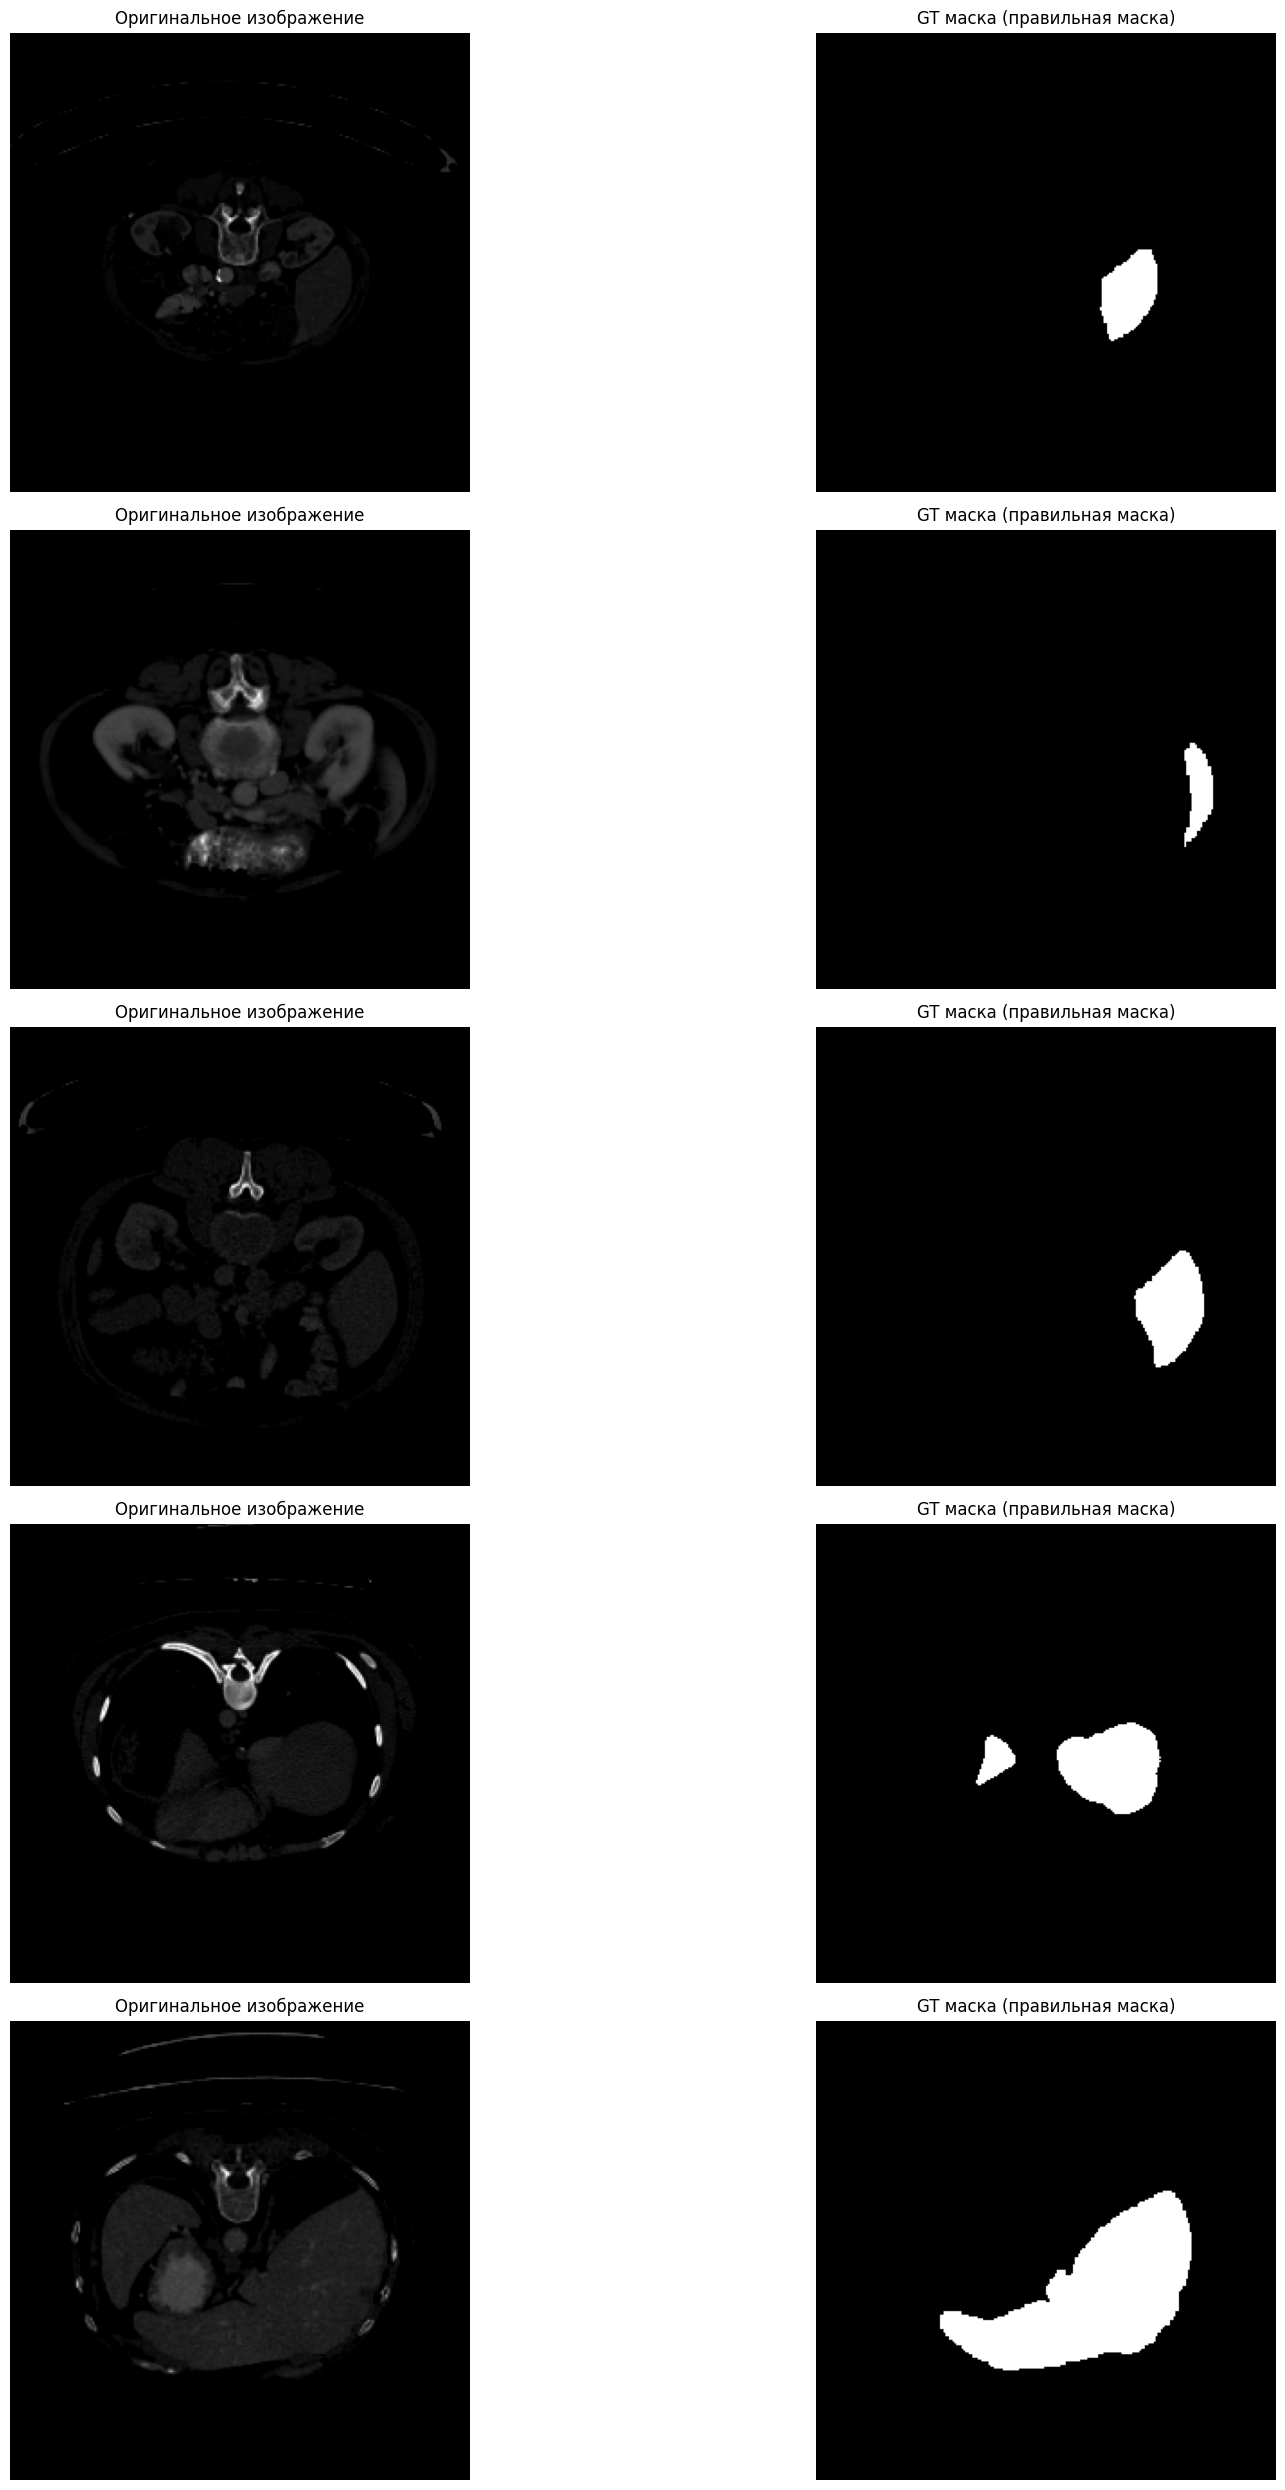

In [ ]:
visualize_dataset(tr_dl, num_images=5)

In [ ]:
# Определение модели, функции потерь и оптимизатора
model = smp.DeepLabV3Plus(classes=1, in_channels=1)
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

model.to(device)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# Параметры обучения
epochs = 50
best_val_loss = float('inf')
best_model_wts = None
history = {
    'train_loss': [],
    'val_loss': [],
}

# Цикл обучения
print("Начало обучения")
for epoch in range(1, epochs + 1):
    start_time = time.time()
    model.train()
    train_loss = 0
    print(f"\nЭпоха {epoch}")
    for batch in tr_dl:
        images, targets = batch
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    end_time = time.time()
    train_loss = train_loss / len(tr_dl)
    history['train_loss'].append(train_loss)
    print("Train Loss:", round(train_loss, 4))
    print(f"Время на эпоху: {round(end_time - start_time, 2)} секунд")

    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dl:
            images, targets = batch
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
    val_loss = val_loss / len(val_dl)
    history['val_loss'].append(val_loss)
    print("Validation Loss:", round(val_loss, 4))

    # Сохранение лучших весов модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()

# Загрузка лучших весов модели
# if best_model_wts:
#     model.load_state_dict(best_model_wts)


Начало обучения

Эпоха 1
Train Loss: 0.1669
Время на эпоху: 21.58 секунд
Validation Loss: 0.0688

Эпоха 2
Train Loss: 0.046
Время на эпоху: 21.72 секунд
Validation Loss: 0.0355

Эпоха 3
Train Loss: 0.0275
Время на эпоху: 21.58 секунд
Validation Loss: 0.0228

Эпоха 4
Train Loss: 0.0204
Время на эпоху: 21.24 секунд
Validation Loss: 0.0227

Эпоха 5
Train Loss: 0.018
Время на эпоху: 21.34 секунд
Validation Loss: 0.0155

Эпоха 6
Train Loss: 0.0141
Время на эпоху: 21.53 секунд
Validation Loss: 0.0132

Эпоха 7
Train Loss: 0.0123
Время на эпоху: 21.37 секунд
Validation Loss: 0.0115

Эпоха 8
Train Loss: 0.0115
Время на эпоху: 21.69 секунд
Validation Loss: 0.0236

Эпоха 9
Train Loss: 0.0116
Время на эпоху: 21.39 секунд
Validation Loss: 0.0103

Эпоха 10
Train Loss: 0.0099
Время на эпоху: 21.59 секунд
Validation Loss: 0.0102

Эпоха 11
Train Loss: 0.0092
Время на эпоху: 21.56 секунд
Validation Loss: 0.0092

Эпоха 12
Train Loss: 0.0088
Время на эпоху: 21.39 секунд
Validation Loss: 0.0132

Эпоха 13
T

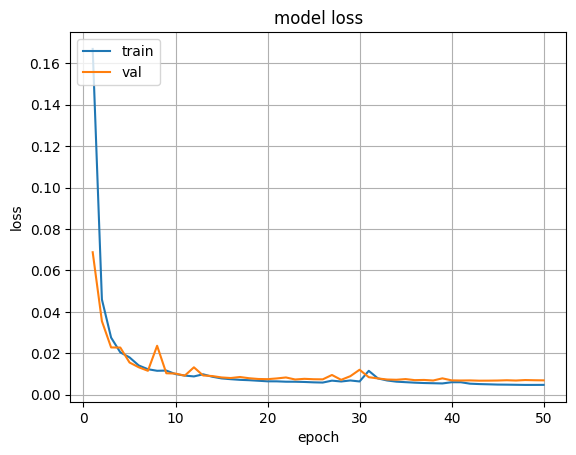

In [ ]:
x_range = np.arange(1, epochs + 1)

plt.plot(x_range, history['train_loss'], label='train')
plt.plot(x_range, history['val_loss'], label='val')

# plt.xticks(np.arange(1, len(history['train_loss'])+1, step=step))
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()

# Отображение графика
plt.show()

In [ ]:
# Сохранение модели
torch.save(model.state_dict(), '/content/drive/MyDrive/Сегментация печени/model4.pth')

In [ ]:
def calculate_jaccard_index(pred, gt):
    intersection = torch.logical_and(gt, pred).sum().item()
    union = torch.logical_or(gt, pred).sum().item()
    if union == 0:
      return 1.0 if intersection == 0 else 0.0
    return intersection / union

jaccard_indices = []
for batch in test_dl:
    images, targets = batch
    images, targets = images.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(images)
    # preds = torch.argmax(outputs, dim=1)
    preds = torch.sigmoid(outputs) > 0.5
    for pred, gt in zip(preds, targets):
        jaccard_index = calculate_jaccard_index(pred, gt)
        jaccard_indices.append(jaccard_index)
average_jaccard_index = np.mean(jaccard_indices)
print("Индекс Жакара:", round(average_jaccard_index, 2))

Индекс Жакара: 0.88


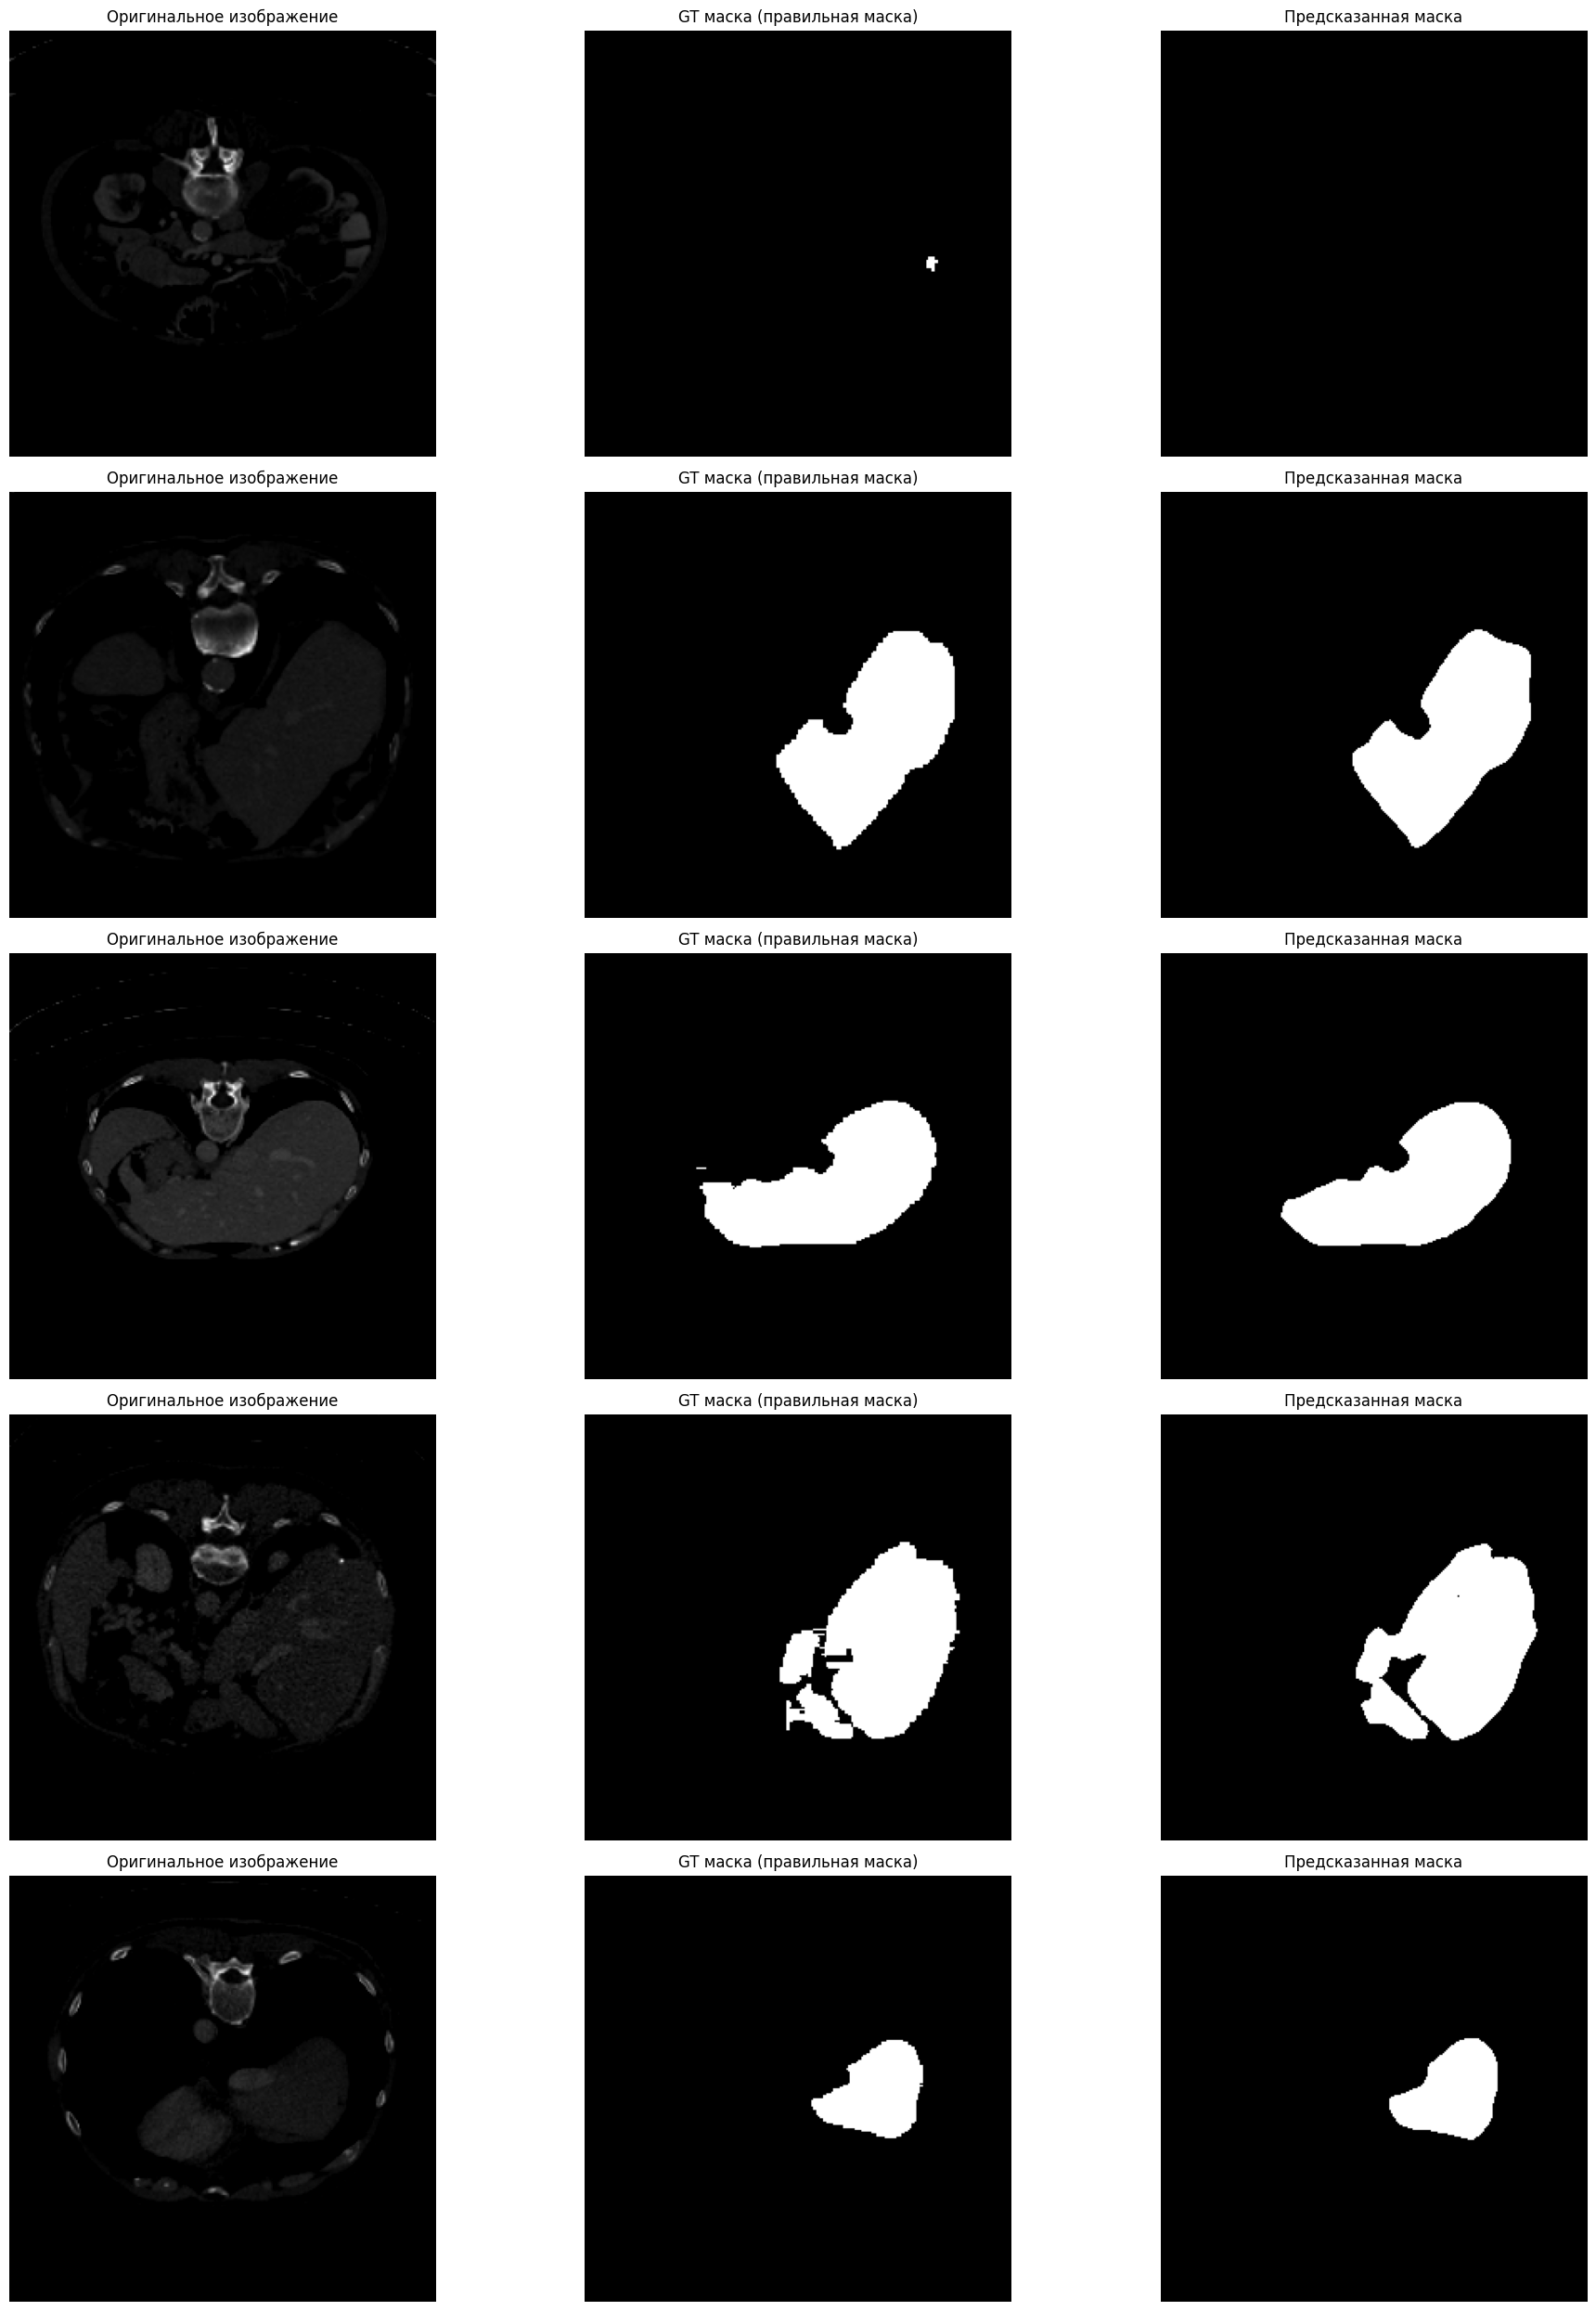

In [ ]:
visualize_dataset(test_dl, num_images=5, model=model)